# **Location Based Taxi Cab Analysis**

In [2]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 27.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039288 sha256=36420b850873ab1dae3d0b6393d8593e58dd04f1334b8d39ce451aef52492bd4
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm
import csv
import random


from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import silhouette_score

from ipywidgets import interactive
from collections import defaultdict
import hdbscan
import folium
import re
import numpy as np
from heapq import heappush, heappop
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
        '#000075', '#808080']*10

Exploratory Data

In [8]:
df = pd.read_csv('/content/drive/MyDrive/project-02/taxi_data.csv')

In [ ]:
df.head()


LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [9]:
df.duplicated(subset=['LON', 'LAT']).values.any()


True

In [10]:
df.isna().values.any()

True

In [11]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [12]:
df.head()


LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [13]:
X = np.array(df[['LON', 'LAT']], dtype='float64')

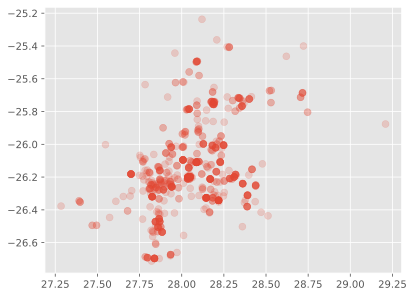

In [14]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

Visualizing Geographical Data

In [15]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9,
               tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

In [16]:
m

Clustering Strength / Performance Metric

In [17]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2,
                        cluster_std=0.5, random_state=4)

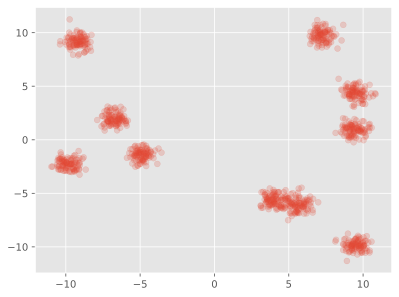

In [18]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

Uploade sample_clusters.npy file

In [19]:
from google.colab import files
uploaded = files.upload()

Saving sample_clusters.npy to sample_clusters.npy


In [20]:
class_predictions = np.load('sample_clusters.npy')

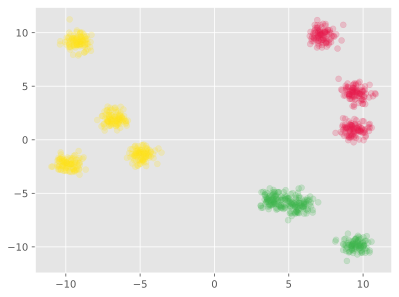

In [21]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [22]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

upload sample_clusters_improved.npy file

In [23]:
from google.colab import files
uploaded = files.upload()

Saving sample_clusters_improved.npy to sample_clusters_improved.npy


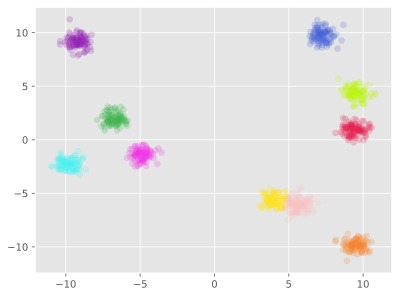

In [24]:
class_predictions = np.load('sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

K-Means Clustering

In [25]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50,
                        n_features=2, cluster_std=1, random_state=4)

In [26]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17,
                   max_iter=x, n_init=1).fit(X_blobs)

    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

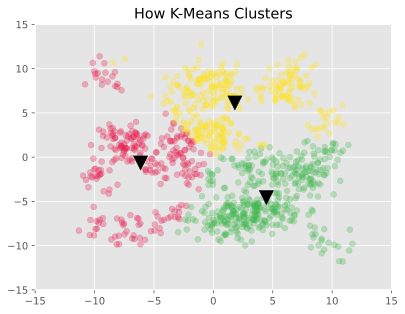

In [27]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0],
                        X_blobs[class_predictions==unique_class][:,1],
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [28]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                 1
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                 1
2  27.83239 -26.53722          Adams Road Taxi Rank                 9
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                 8
4  28.10144 -26.10567      Alexandra Main Taxi Rank                 4

In [30]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup = folium.Popup(row[cluster_column]),
            #popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)

    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6527069281516621


1) By using **Quadtree**

In [43]:
class QuadTree:
    def __init__(self, boundary, capacity):
        self.boundary = boundary  # Boundary of the quadtree
        self.capacity = capacity  # Maximum number of points in a node
        self.points = []  # List of points in the quadtree node
        self.subdivided = False  # Whether the quadtree node has been subdivided

    def insert(self, point):
        # Insert a point into the quadtree
        if not self.boundary.contains(point):
            return False  # Point is outside the quadtree boundary
        if len(self.points) < self.capacity:
            self.points.append(point)
            return True
        else:
            if not self.subdivided:
                self.subdivide()
            # Insert the point into one of the subquadrants
            for child in self.children:
                if child.insert(point):
                    return True

    def subdivide(self):
        # Subdivide the quadtree into four quadrants
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.width / 2
        h = self.boundary.height / 2
        nw = Rectangle(x - w/2, y - h/2, w, h)
        self.children = [
            QuadTree(nw, self.capacity),
            QuadTree(Rectangle(x + w/2, y - h/2, w, h), self.capacity),
            QuadTree(Rectangle(x - w/2, y + h/2, w, h), self.capacity),
            QuadTree(Rectangle(x + w/2, y + h/2, w, h), self.capacity)
        ]
        self.subdivided = True

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
class Rectangle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height


In [45]:
def read_points_from_csv(file_path):
    points = []
    with open(file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for idx, row in enumerate(csv_reader, start=2):  # start counting from 2 to account for header
            try:
                x, y = map(float, row[:2])
                points.append(Point(x, y))
            except ValueError:
                print(f"Error converting row {idx} to float: {row}")
    return points

# Perform K-Means clustering using QuadTree
def k_means_with_quadtree(points, k, iterations=100):
    # Initialize cluster centroids randomly
    centroids = random.sample(points, k)
    quadtree_boundary = Rectangle(min(p.x for p in points), min(p.y for p in points),
                                  max(p.x for p in points) - min(p.x for p in points),
                                  max(p.y for p in points) - min(p.y for p in points))
    quadtree = QuadTree(quadtree_boundary, len(points))

    # Perform K-Means iterations
    for _ in range(iterations):
        # Assign points to clusters
        clusters = [[] for _ in range(k)]
        for point in points:
            min_dist = float('inf')
            closest_centroid = None
            for i, centroid in enumerate(centroids):
                dist = np.sqrt((point.x - centroid.x)**2 + (point.y - centroid.y)**2)
                if dist < min_dist:
                    min_dist = dist
                    closest_centroid = i
            clusters[closest_centroid].append(point)

        # Update centroids
        for i in range(k):
            if clusters[i]:
                centroids[i] = Point(np.mean([p.x for p in clusters[i]]), np.mean([p.y for p in clusters[i]]))

    # Calculate Silhouette Score
    all_points = [point for cluster in clusters for point in cluster]
    labels = [i for i, cluster in enumerate(clusters) for _ in cluster]
    silhouette_avg = silhouette_score([np.array([p.x, p.y]) for p in all_points], labels)
    print("Silhouette Score:", silhouette_avg)

    return clusters

# Example usage
file_path = '/content/drive/MyDrive/project-02/taxi_data.csv'
points = read_points_from_csv(file_path)
k = 3  # Number of clusters

# Perform K-Means clustering using QuadTree
clusters = k_means_with_quadtree(points, k)
for i, cluster in enumerate(clusters):
    print(f'Cluster {i+1}: {len(cluster)} points')


Error converting row 839 to float: ['', '', '']
Silhouette Score: 0.43370387764528767
Cluster 1: 264 points
Cluster 2: 148 points
Cluster 3: 425 points


In [32]:
m

Final Score by Using Quadtree

In [33]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)

    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette

print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}')

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  2%|▏         | 2/98 [00:00<00:09, 10.56it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

K=99
Silhouette Score: 0.708499624089545


2) A* Algo

In [ ]:


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"({self.x}, {self.y})"

class Cluster:
    def __init__(self, center):
        self.center = center
        self.points = [center]

def euclidean_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

def a_star_clustering(points, k):
    # Initialize clusters with random centers
    clusters = [Cluster(points[i]) for i in np.random.choice(len(points), k, replace=False)]

    # Create a priority queue for the frontier
    frontier = []
    for cluster_index, cluster in enumerate(clusters):
        for point in points:
            distance = euclidean_distance(cluster.center, point)
            heappush(frontier, (distance, cluster_index, point))

    # Perform A* search
    while frontier and len(clusters) < k:
        _, closest_cluster_index, point = heappop(frontier)
        closest_cluster = clusters[closest_cluster_index]
        closest_cluster.points.append(point)
        closest_cluster.center = Point(np.mean([p.x for p in closest_cluster.points]), np.mean([p.y for p in closest_cluster.points]))

        # Update priorities for points in the frontier
        for cluster_index, cluster in enumerate(clusters):
            distance = euclidean_distance(cluster.center, point)
            heappush(frontier, (distance, cluster_index, point))

    return clusters

# Example usage
points = [Point(1, 2), Point(3, 4), Point(5, 6), Point(7, 8), Point(9, 10)]
k = 2  # Number of clusters

clusters = a_star_clustering(points, k)
for i, cluster in enumerate(clusters):
    print(f'Cluster {i+1}: Center={cluster.center}, Points={cluster.points}')


Cluster 1: Center=(1, 2), Points=[(1, 2)]
Cluster 2: Center=(5, 6), Points=[(5, 6)]


3) **DBSCAN**

In [ ]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [ ]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [ ]:
m = create_map(df, 'CLUSTERS_DBSCAN')


print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.923213824804447
Silhouette outliers as singletons: 0.5667489347252957


In [ ]:
m

4) HDBSCAN By **ARIMA**

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import hdbscan

# Example time series data
time_series_data = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2020', periods=1000))

# Preprocess the time series data with ARIMA (Example only, adjust as needed)
model = ARIMA(time_series_data, order=(5,1,0))
results = model.fit()
forecast_values = results.forecast(steps=100)  # Example forecast for the next 100 steps

# Convert time series data into feature vectors (Example only, adjust as needed)
# You might extract features like mean, variance, trend, etc.
feature_vectors = []
for i in range(len(time_series_data)):
    # Example: Using mean and variance as features
    mean_value = time_series_data[:i+1].mean()
    var_value = time_series_data[:i+1].var()
    feature_vectors.append([mean_value, var_value])

# Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(feature_vectors)

# Explore the clusters
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    cluster_points = time_series_data[cluster_labels == label]
    print(f'Cluster {label}: {cluster_points}')


Cluster -1: 2020-01-01   -0.704216
2020-01-02    1.399119
2020-01-03    0.363188
2020-01-04    0.050744
2020-01-05    0.554875
2020-01-06   -0.239715
2020-01-07    1.514180
2020-01-08   -2.309120
2020-01-09   -0.144164
2020-01-10    0.042631
2020-01-11    0.759298
2020-01-12   -0.355809
2020-01-13    0.524350
2020-01-14    0.131778
2020-01-15    0.624274
2020-01-16   -1.818769
2020-01-17    0.244839
2020-01-18    0.152294
2020-01-21   -1.585520
2020-01-22   -1.720975
2020-01-23   -0.396916
2020-01-24   -1.351961
2020-01-25   -1.071558
2020-01-26   -1.555756
2020-01-27    1.398499
2020-01-28    0.799952
2020-01-29   -0.025454
2020-01-30    1.105543
2020-01-31   -0.156894
2020-02-01   -2.183866
2020-02-02    0.087394
2020-02-03    1.468162
2020-02-04   -0.684677
2020-02-05   -1.251450
2020-02-06    1.804672
2020-02-07   -1.185606
2020-02-08    1.272429
2020-02-09   -0.492270
2020-02-10   -1.532597
2020-02-11    0.684331
2020-02-12    0.265645
2020-02-13    0.597446
2020-02-14   -0.118132

In [ ]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2,
                        cluster_selection_epsilon=0.01)
#min_cluster_size
#min_samples
#cluster_slection_epsilon

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [ ]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504354649553
Silhouette outliers as singletons: 0.6389924831127337


In [ ]:
hdbscan.HDBSCAN?

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [ ]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [ ]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [ ]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
predictions = classifier.predict(X_predict)

In [ ]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']


In [ ]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [ ]:
m = create_map(df, 'CLUSTER_hybrid')

In [ ]:
m


Text(0.5, 0, 'Cluster Sizes')

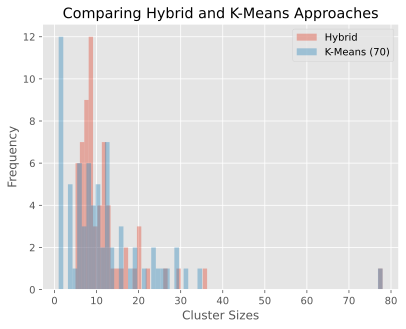

In [ ]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4,
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')